In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to

In [3]:
release14_hc_meta_mt_uri =   "SG10K-SV-Release-1.4-HighConfidenceSV-WithMetadata-correctrsid.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(release14_hc_meta_mt_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [5]:
mt = hl.variant_qc(mt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [8]:
# find SVs with allele frequency greater than 0.95
mt_large_af = mt.filter_rows(mt.variant_qc.AF[1]>=0.95, keep=True)
mt_large_af.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(465, 5487)

In [7]:
df = mt.select_rows(
    svtype = mt.callers_info.SVTYPE,
    ac = mt.variant_qc.AC[1]
).rows().select('svtype', 'ac').to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df2 = df.drop(['locus.contig', 'locus.position', 'alleles'], axis=1)
df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      svtype    ac
0        DUP    97
1        DUP     2
2        DUP    45
3        DUP   312
4        INS     1
...      ...   ...
73030    DUP  1433
73031    DUP    10
73032    DUP     1
73033    DUP     2
73034    DUP     2

[73035 rows x 2 columns]

In [9]:
%%sh
pip install boto3

In [10]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


df = (mt
      #.filter_rows((hl.is_missing(mt.info.manta.PASS_GT2_filter)) | (mt.info.manta.PASS_GT2_filter=="PASS"), keep=True)
      .select_rows(svtype = mt.callers_info.SVTYPE, 
                   ac = mt.variant_qc.AC[1])
      .rows()
      .select('svtype', 'ac')
      .to_pandas()
     )

# Separate 'ac' values for DEL and DUP SV types
ac_del = df[df['svtype'] == 'DEL']['ac']
ac_dup = df[df['svtype'] == 'DUP']['ac']
ac_ins = df[df['svtype'] == 'INS']['ac']

# Calculate cumulative distributions for DEL and DUP SV types
ac_del_counts = ac_del.value_counts().sort_index()
ac_dup_counts = ac_dup.value_counts().sort_index()
ac_ins_counts = ac_ins.value_counts().sort_index()

cum_dist_del = ac_del_counts.cumsum() / ac_del_counts.sum()
cum_dist_dup = ac_dup_counts.cumsum() / ac_dup_counts.sum()
cum_dist_ins = ac_ins_counts.cumsum() / ac_ins_counts.sum()


# Plot cumulative distribution of allele counts (ac)
plt.figure(figsize=(8, 6))
plt.plot(cum_dist_del.index, cum_dist_del.values, label='DEL', marker='', linestyle='-')
plt.plot(cum_dist_dup.index, cum_dist_dup.values, label='DUP', marker='', linestyle='-')
plt.plot(cum_dist_ins.index, cum_dist_ins.values, label='INS', marker='', linestyle='-')

plt.title('Cumulative Distribution Plot of Alt Allele Count (AC)')
plt.xlabel('Alt Allele Count (AC)')
plt.ylabel('Fraction of samples')
plt.xscale('log')  # Set x-axis to log scale (base 10)
#plt.yscale('log')  # Set x-axis to log scale (base 10)

#plt.xlim(left=1)  # Ensure x-axis starts from 1 (log scale)
#plt.xlim(left=0)  # Ensure x-axis starts from 0
#plt.ylim(bottom=0, top=1)  # Set y-axis limits between 0 and 1
plt.legend()

plt.grid(True)
plt.show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

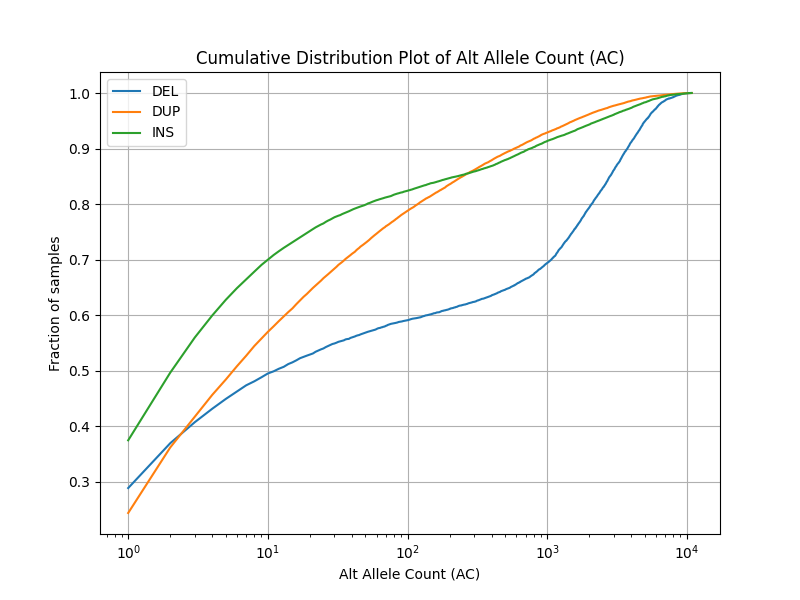

In [13]:
%matplot plt

In [14]:
save_fig_to_s3(plt, "Figures", "Figure2/Fig2_supplementary_acdistribution.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Plot by common, rare, ultra-rare definition

In [11]:
mt2 = mt.annotate_rows(
    AF_class = hl.case()
            .when((mt.variant_qc.AF[1] < 0.001),  "Ultra-rare")
            .when((mt.variant_qc.AF[1] >= 0.001) & (mt.variant_qc.AF[1] < 0.01), "Rare")
            .when((mt.variant_qc.AF[1] >= 0.01), "Common")
            .default("NA") 
)
mt2.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [12]:
df = mt2.select_rows(
    svtype = mt2.callers_info.SVTYPE,
    afclass = mt2.AF_class,
).rows().select('svtype', 'afclass').to_pandas()
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      locus.contig  locus.position              alleles svtype     afclass
0             chr1           54720           [C, <DUP>]    DUP      Common
1             chr1           66534           [T, <DUP>]    DUP  Ultra-rare
2             chr1           83963           [A, <DUP>]    DUP        Rare
3             chr1           99061           [C, <DUP>]    DUP      Common
4             chr1          187139  [C, <INS:ME:LINE1>]    INS  Ultra-rare
...            ...             ...                  ...    ...         ...
73030        chr22        50644070           [A, <DUP>]    DUP      Common
73031        chr22        50644090           [G, <DUP>]    DUP      Common
73032        chr22        50645312           [T, <DUP>]    DUP  Ultra-rare
73033        chr22        50685882           [A, <DUP>]    DUP      Common
73034        chr22        50702186           [A, <DUP>]    DUP  Ultra-rare

[73035 rows x 5 columns]

In [13]:
df2 = df.drop(['locus.contig', 'locus.position', 'alleles'], axis=1)
df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      svtype     afclass
0        DUP      Common
1        DUP  Ultra-rare
2        DUP        Rare
3        DUP      Common
4        INS  Ultra-rare
...      ...         ...
73030    DUP      Common
73031    DUP      Common
73032    DUP  Ultra-rare
73033    DUP      Common
73034    DUP  Ultra-rare

[73035 rows x 2 columns]

In [14]:
counts_df2= df2.groupby(['svtype', 'afclass']).size().reset_index(name='counts')
counts_df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  svtype     afclass  counts
0    DEL      Common    4742
1    DEL        Rare    1110
2    DEL  Ultra-rare    5708
3    DUP      Common    9329
4    DUP        Rare    6949
5    DUP  Ultra-rare   16186
6    INS      Common    5205
7    INS        Rare    3799
8    INS  Ultra-rare   20007

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()

palette=[  '#980043' , '#df65b0' , '#d4b9da']
#set seaborn plotting aesthetics

sns.set(rc={'figure.figsize':(15,15)})
sns.set(style='whitegrid')

#create grouped bar chart
sns.barplot(x='svtype', y='counts', hue='afclass', data=counts_df2, palette = palette) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='svtype', ylabel='counts'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

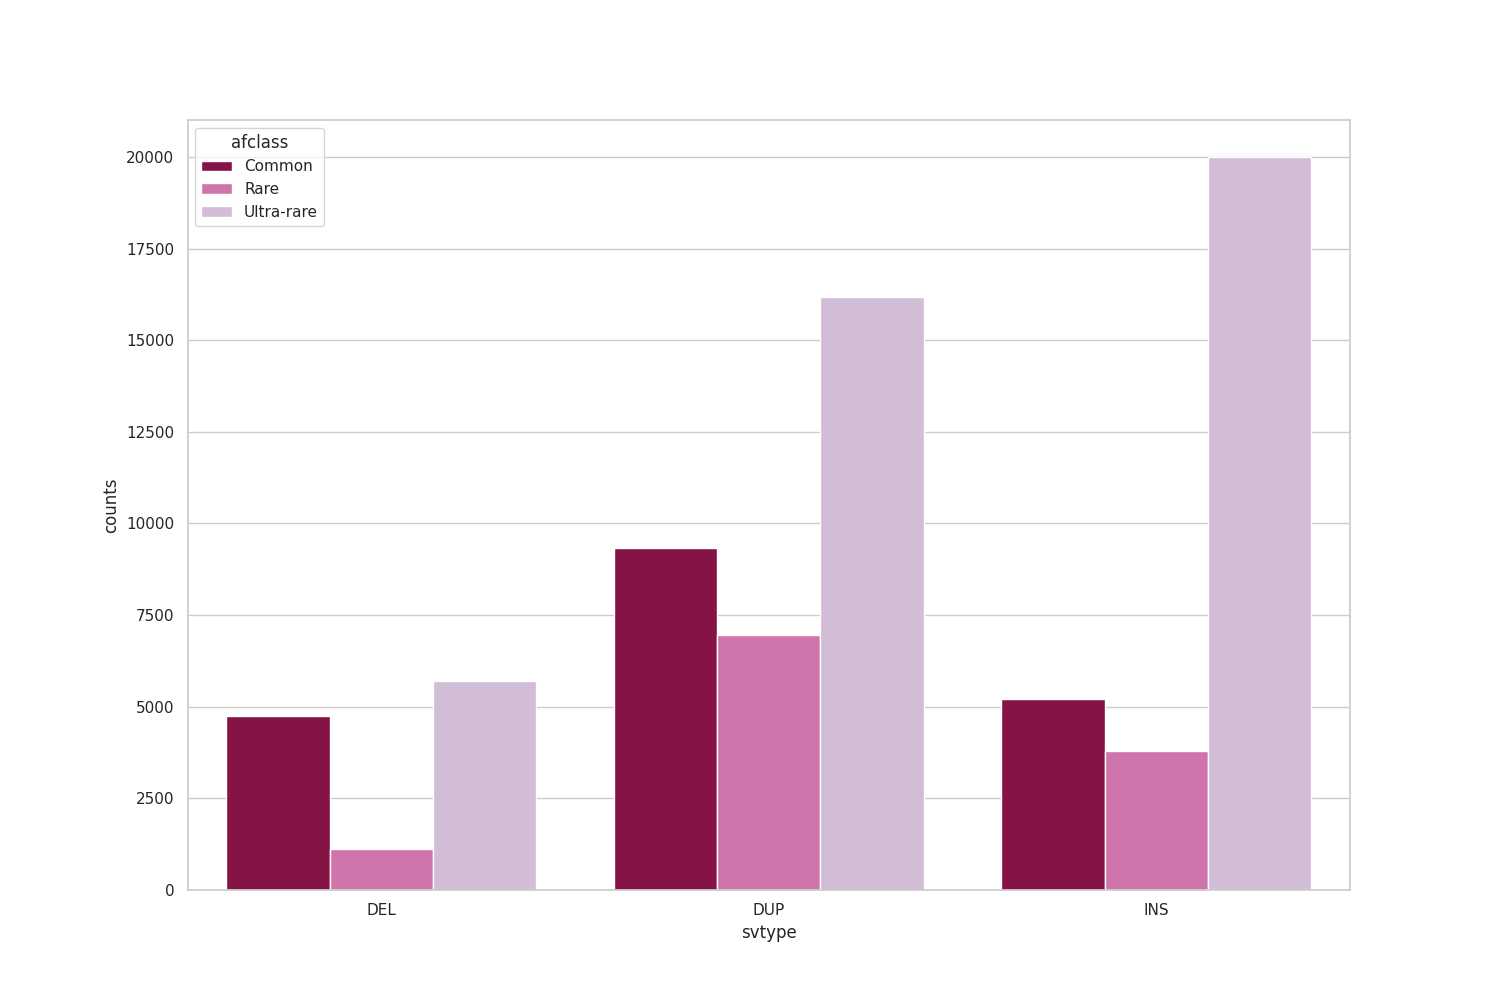

In [18]:
%matplot plt

In [19]:
save_fig_to_s3(plt, "Figures", "Figure2/Fig2c_AFcounts_byAFclass_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…